# Prepare input parameters

In [1]:
from bokeh.plotting import output_notebook
from bokeh.plotting import show

import geopandas as gpd

from shapely.geometry import Point
from shapely.ops import linemerge

from easy_map_bokeh import EasyMapBokeh

from osmgt import OsmGt

from graph_tool.topology import shortest_path


output_notebook()


location = "Roanne"


Loading BokehJS ...

# Get POIs

In [2]:
%%time

poi_from_location = OsmGt.poi_from_location(location)
poi_from_location_gdf = poi_from_location.get_gdf()

2020-08-23 10:25:34 - OsmGtPoi        - INFO     : From location: Roanne
2020-08-23 10:25:34 - OsmGtPoi        - INFO     : Loading data...
2020-08-23 10:25:34 - OsmGtPoi        - INFO     : NominatimApi: Query 200:OK in 0.172733 sec.
2020-08-23 10:25:35 - OsmGtPoi        - INFO     : OverpassApi: Query 200:OK in 0.635322 sec.
2020-08-23 10:25:35 - OsmGtPoi        - INFO     : Formating data
2020-08-23 10:25:35 - OsmGtPoi        - INFO     : Prepare Geodataframe
2020-08-23 10:25:35 - OsmGtPoi        - INFO     : Geodataframe Ready
CPU times: user 94.6 ms, sys: 20.6 ms, total: 115 ms
Wall time: 907 ms


# Get Roads

In [3]:
%%time
roads_from_location = OsmGt.roads_from_location(location, mode="vehicle", additionnal_nodes=poi_from_location_gdf)
roads_from_location_gdf = roads_from_location.get_gdf()

2020-08-23 10:25:35 - OsmGtRoads      - INFO     : From location: Roanne
2020-08-23 10:25:35 - OsmGtRoads      - INFO     : Loading data...
2020-08-23 10:25:35 - OsmGtRoads      - INFO     : NominatimApi: Query 200:OK in 0.122257 sec.
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : OverpassApi: Query 200:OK in 0.816904 sec.
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Formating data
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Network cleaning STARTS!
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Starting: Adding new nodes on the network
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Find nearest line for each node
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Split line
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Done: Adding new nodes on the network ; connections_added: 178, line_split: 176
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Starting: Find intersections
2020-08-23 10:25:36 - OsmGtRoads      - INFO     : Done: Find intersections
2020

# Plot Data

In [4]:
# apply colors based on topology field
roads_from_location_gdf = roads_from_location_gdf[["topo_uuid", "id", "topology", "geometry"]]

roads_gdf_unchanged = roads_from_location_gdf.loc[roads_from_location_gdf["topology"] == "unchanged"]
roads_gdf_added = roads_from_location_gdf.loc[roads_from_location_gdf["topology"] == "added"]
roads_gdf_split = roads_from_location_gdf.loc[roads_from_location_gdf["topology"] == "split"]

poi_from_location_gdf = poi_from_location_gdf[["topo_uuid", "id", "geometry"]]


# node added on the graph
columns_without_geometry = roads_gdf_added.columns.tolist()
columns_without_geometry.remove("geometry")
node_added_on_the_graph = roads_gdf_added.copy(deep=True)
node_added_on_the_graph["geometry"] = node_added_on_the_graph["geometry"].apply(lambda x: Point(x.coords[-1]))
node_added_on_the_graph = node_added_on_the_graph[["topo_uuid", "id", "geometry"]]

#line split segments limits
columns_without_geometry = roads_gdf_split.columns.tolist()
columns_without_geometry.remove("geometry")
line_split_segments_limits = roads_gdf_split.copy(deep=True)
line_split_segments_limits["geometry"] = line_split_segments_limits["geometry"].apply(lambda x: [[Point(f) for f in x.coords][0], [Point(f) for f in x.coords][-1]])
line_split_segments_limits.set_index(columns_without_geometry, inplace=True)
line_split_segments_limits = line_split_segments_limits["geometry"].explode().reset_index()
line_split_segments_limits = line_split_segments_limits[["topo_uuid", "id", "geometry"]]
line_split_segments_limits = gpd.GeoDataFrame(line_split_segments_limits, geometry='geometry', crs="EPSG:4326")


layers_to_add = [
    {
        "input_gdf": roads_gdf_unchanged,
        "legend": "roads unchanged",
        "color": "black",
    },
    {
        "input_gdf": roads_gdf_added,
        "legend": "roads added",
        "color": "green",
    },
    {
        "input_gdf": roads_gdf_split,
        "legend": "roads split",
        "color": "orange",
    },
    {
        "input_gdf": poi_from_location_gdf,
        "legend": "POIs",
        "style": "square",
        "fill_color": "blue",
        "size": 9
    },
    {
        "input_gdf": line_split_segments_limits,
        "legend": "roads split nodes",
        "fill_color": "brown",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": node_added_on_the_graph,
        "legend": "Nodes added",
        "fill_color": "red",
    },

]

my_map = EasyMapBokeh(
    "My roads and POIs",
    layers=layers_to_add
)
show(my_map.figure)

/opt/conda/envs/osmgt/lib/python3.8/site-packages/geopandas/geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


# Get network and display it

2020-08-23 10:25:40 - OsmGtRoads      - INFO     : Prepare graph


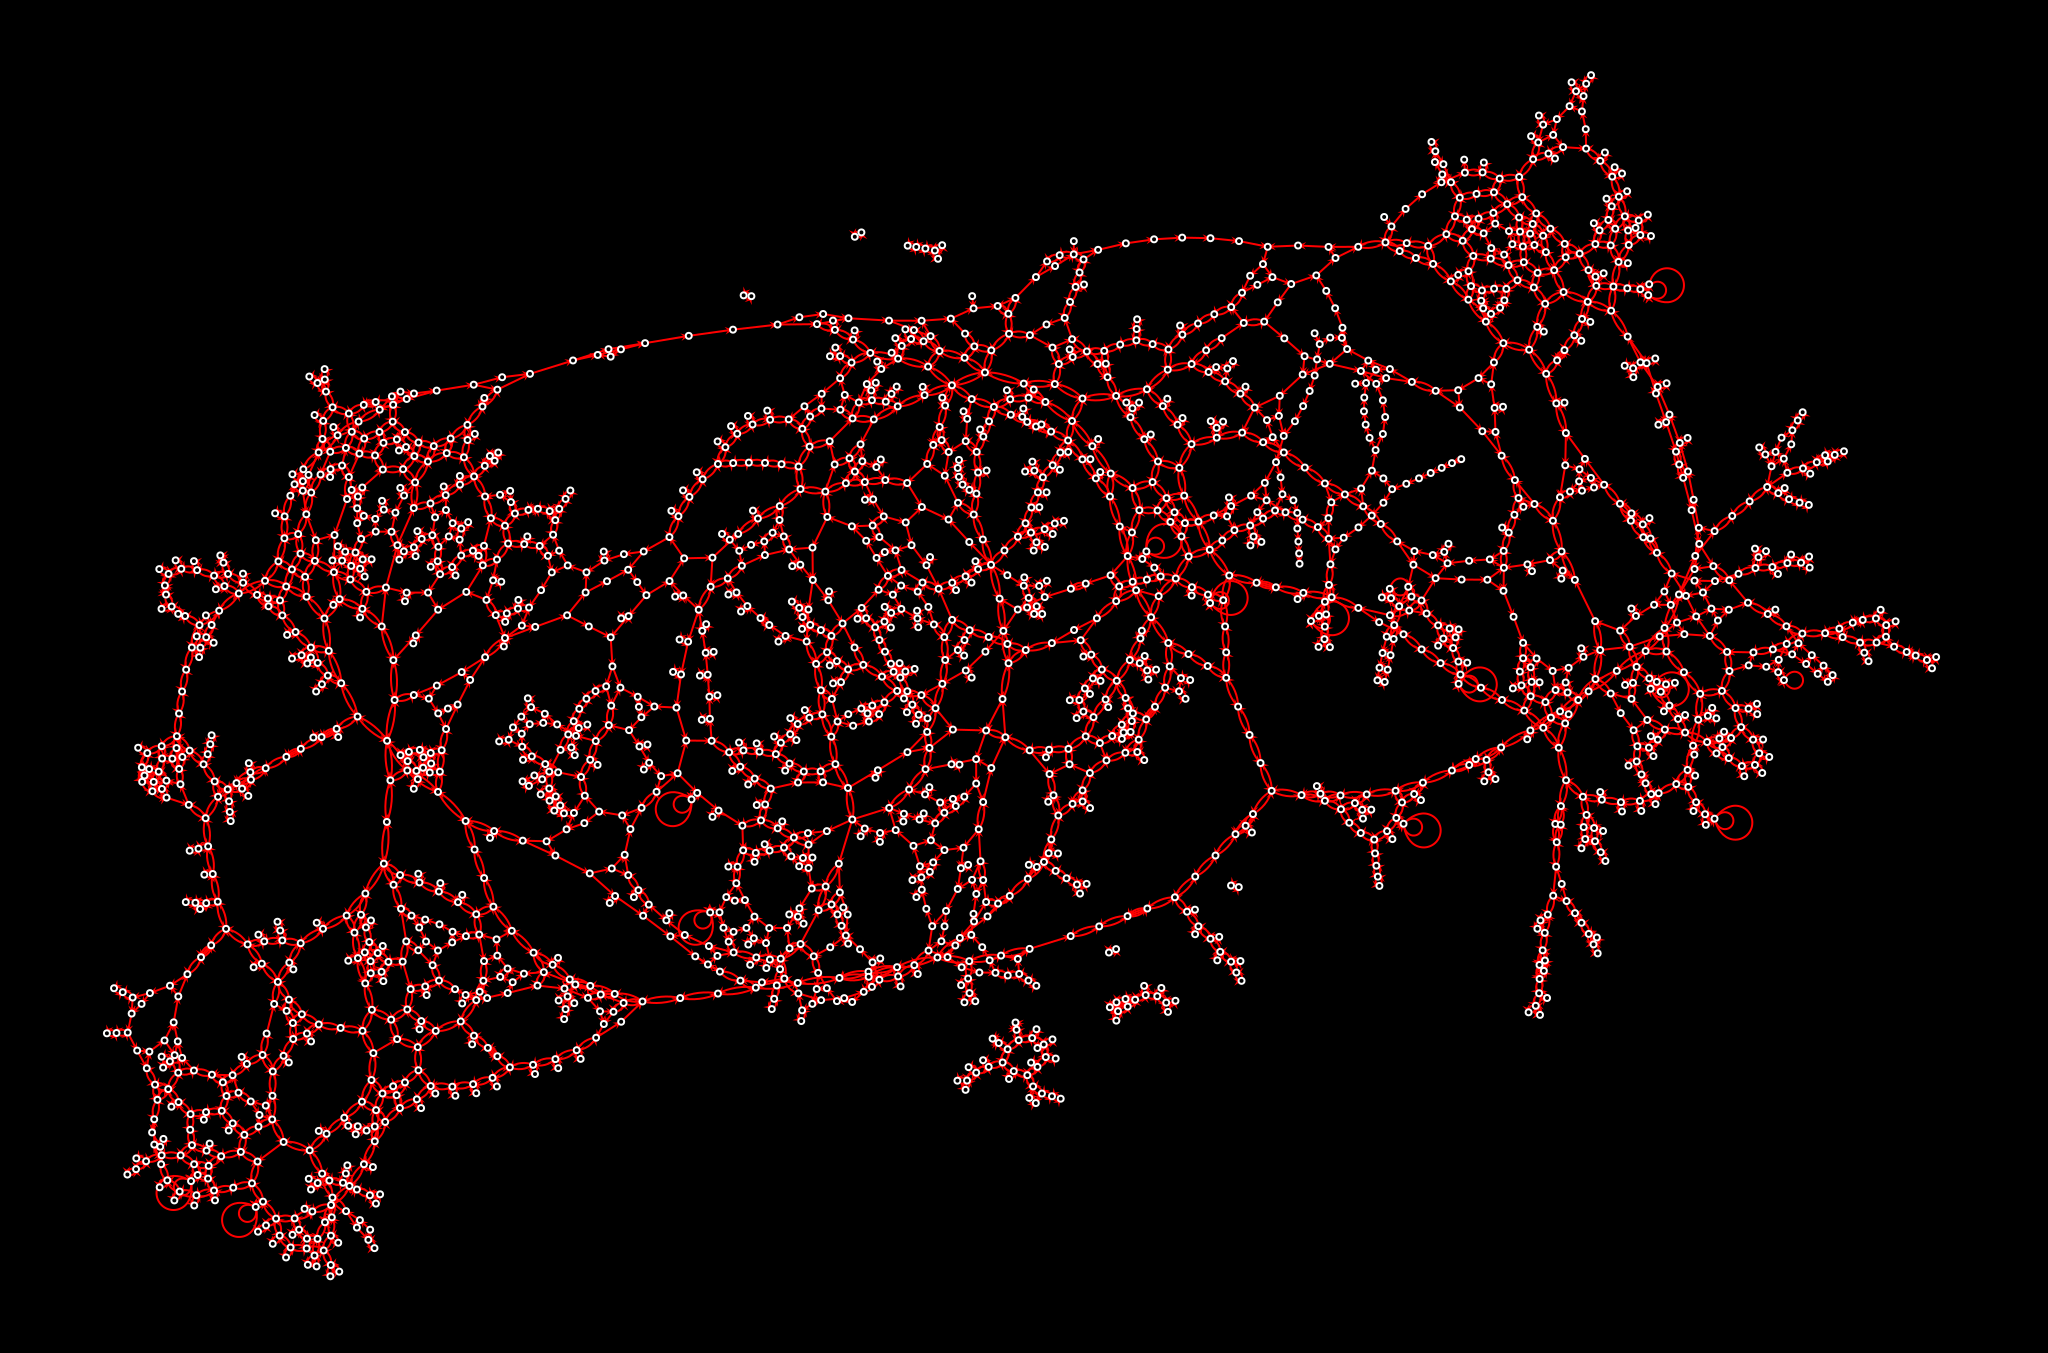

CPU times: user 11.2 s, sys: 61.1 ms, total: 11.3 s
Wall time: 7.47 s


In [5]:
%%time
graph = roads_from_location.get_graph()

graph.plot()


# Compute a shortest path and display it

## By using the hard way

In [6]:
%%time
# now, we have to define a start point and a end point and get their wkt
start_node_topo_uuid = 47
end_node_topo_uuid = 63

# 'topo_uuid' is generated by osmgt (during the topology processing).
# Some roads has been split that's whyso this id has been created.
start_node_gdf = poi_from_location_gdf[poi_from_location_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = poi_from_location_gdf[poi_from_location_gdf['topo_uuid'] == end_node_topo_uuid]

start_node_wkt = start_node_gdf.iloc[0]["geometry"].wkt
end_node_wkt = end_node_gdf.iloc[0]["geometry"].wkt

# the graph have some methods (graph-tools method always exists!) to find egdes, vertices... Let's use the .find_vertex_from_name(). the wkt is the vertex name...
source_vertex = graph.find_vertex_from_name(start_node_wkt)
target_vertex = graph.find_vertex_from_name(end_node_wkt)

# shortest path computing...
path_vertices, path_edges = shortest_path(
    graph,
    source=source_vertex,
    target=target_vertex,
    weights=graph.edge_weights  # weigth is based on line length
)

# get path by using edge names
roads_ids = [
    graph.edge_names[edge]
    for edge in path_edges
]

roads_gdf_copy = roads_from_location_gdf.copy(deep=True)
shortest_path_found = roads_gdf_copy[roads_from_location_gdf['topo_uuid'].isin(roads_ids)].to_crs(3857)['geometry'].to_list()
shortest_path_found_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:3857", geometry=[linemerge(shortest_path_found)])

layers_to_add = [
    {
        "input_gdf": shortest_path_found_gdf,
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = EasyMapBokeh(
    "My shortest path",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

CPU times: user 248 ms, sys: 8.5 ms, total: 257 ms
Wall time: 257 ms


## By using the easy way: OsmGt can help you

In [7]:
%%time
start_node = Point(4.0697088, 46.0410178)
end_node = Point(4.0757785, 46.0315038)

shortest_paths = OsmGt.shortest_path_from_location(
    "Roanne",
    [
        (start_node, end_node),
        (start_node, end_node),
        (start_node, end_node),
        (start_node, end_node),
        (start_node, end_node),
        (start_node, end_node)
    ],
    mode="pedestrian"
)
layers_to_add = [
    {
        "input_gdf": shortest_paths[["geometry"]],
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = EasyMapBokeh(
    "My shortest path",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

2020-08-23 10:25:47 - OsmGtShortestPath - INFO     : From location: Roanne
2020-08-23 10:25:47 - OsmGtShortestPath - INFO     : Loading data...
2020-08-23 10:25:47 - OsmGtShortestPath - INFO     : NominatimApi: Query 200:OK in 0.133468 sec.
2020-08-23 10:25:48 - OsmGtShortestPath - INFO     : OverpassApi: Query 200:OK in 0.841524 sec.
2020-08-23 10:25:48 - OsmGtShortestPath - INFO     : Formating data
2020-08-23 10:25:48 - OsmGtShortestPath - INFO     : Network cleaning STARTS!
2020-08-23 10:25:49 - OsmGtShortestPath - INFO     : Starting: Adding new nodes on the network
2020-08-23 10:25:49 - OsmGtShortestPath - INFO     : Find nearest line for each node
2020-08-23 10:25:49 - OsmGtShortestPath - INFO     : Split line
2020-08-23 10:25:49 - OsmGtShortestPath - INFO     : Done: Adding new nodes on the network ; connections_added: 2, line_split: 2
2020-08-23 10:25:49 - OsmGtShortestPath - INFO     : Starting: Find intersections
2020-08-23 10:25:49 - OsmGtShortestPath - INFO     : Done: Fin

CPU times: user 1.82 s, sys: 35.6 ms, total: 1.86 s
Wall time: 2.91 s


# Compute some isochrones and display them

In [8]:
%%time
source_node = poi_from_location_gdf[poi_from_location_gdf['topo_uuid'] == start_node_topo_uuid]

isochrones_polygon_values = {
    2: "#d9ef8b",
    5: "#fee08b",
    10: "#f46d43"
}

isochrones_line_values = {
    2: "#668100",
    5: "#e2a803",
    10: "#962603"
}

trip_speed = 3

location_point = source_node.iloc[0]["geometry"]
isochrones_from_location, isochrones_lines_from_location = OsmGt.isochrone_from_coordinates(
    location_point,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_from_location["color"] = isochrones_from_location["iso_name"].map(lambda x: isochrones_polygon_values[x])
isochrones_from_location.loc[isochrones_from_location.index, 'iso_name'] = isochrones_from_location['iso_name'].astype(str) + " min."
isochrones_lines_from_location["color"] = isochrones_lines_from_location["iso_name"].map(lambda x: isochrones_line_values[x])
isochrones_lines_from_location.loc[isochrones_lines_from_location.index, 'iso_name'] = isochrones_lines_from_location['iso_name'].astype(str) + " min."


layers_to_add = [
    {
        "input_gdf": isochrones_from_location,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "white",
        "fill_alpha": 0.7
    },
    {
        "input_gdf": source_node,
        "legend": "Source node",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_lines_from_location,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = EasyMapBokeh(
    "isochrone",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

2020-08-23 10:25:50 - OsmGtIsochrone  - INFO     : From bbox: (4.064318908295283, 46.037276316540144, 4.075098691704716, 46.044759030109994)
2020-08-23 10:25:50 - OsmGtIsochrone  - INFO     : Loading data...
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.321888 sec.
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Formating data
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Network cleaning STARTS!
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Split line
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Done: Adding new nodes on the network ; connections_added: 1, line_split: 1
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2020-08-23 10:25:51 - OsmGtIsochrone  - INFO     : Done: Find intersections
2020-08-23 10:25:51 - OsmGtIsochron

CPU times: user 535 ms, sys: 29.7 ms, total: 565 ms
Wall time: 874 ms
